<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_share_cirlce.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# 3.3 Data Sharing
Science is much more impactful once it's shared. Therefore, we are going to learn how to 
open up our scientific output from a cloud platform, so that is openly available - and 
has the chance to make the impact it should.
- Reuse the workflow we have used before for creating the snow covered area
- Select AOI,
- Recreate process graph, 
- Download results for one time-step
  - A Snow Cover Area map in the COG format
  - A STAC metadata item that is provided with the result from openEO at CDSE
- Adapt the STAC item
- Upload the results and make them available openly via a STAC browser and web map


## Libraries

Start by creating the folders and data files needed to complete the exercise

In [1]:
!cp -r $DATA_PATH/33_results/ $HOME/

In [2]:
!cp $DATA_PATH/_33_cubes_utilities.py $HOME/

In [3]:
import json
import os
import subprocess
from datetime import datetime

import openeo
import numpy as np
import leafmap
import geopandas as gpd
import shapely
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import rioxarray as rio
import xarray
from osgeo import gdal

from _33_cubes_utilities import (
    calculate_sca,
    visualize_bbox,
    create_bounding_box,
    extract_metadata_geometry, 
    extract_metadata_time
)

Import utility functions

## Login

Connect to the copernicus dataspace ecosystem.

In [4]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

Authenticate login

In [5]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Check if the login worked

In [ ]:
conn.describe_account()

## Select an Area of Interest and Time Frame

Start by selecting a center point of the area you would like to analyse from the map shown below. The starting extent is the full alps. Zoom in to an area and choose a region that has not been mapped yet. *Make sure not to overlap too much with already mapped areas by having a look at the [STAC Collection](https://esa.pages.eox.at/cubes-and-clouds-catalog/browser/#/?.language=en)*. It's a community mapping project :)
Create a 1 km bounding box around it. This will be the area you are calculating the snow covered area for. 


**Attention:**
 Execute the cell below to show the map. Zoom to a location you want to analyze. Use the location symbol to select a point. A marker appears on the map. This is the center of your area of interest

In [7]:
m = leafmap.Map(center=(47.005, 11.507), zoom=7.5)
m

Map(center=[47.005, 11.507], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

**Attention:**
 Now this cell will get the coordinates of the marker you have placed. This will create a 1 km bounding box around the chosen location. And visualize it in the map above. *The marker moves to the center when you zoom in*

In [8]:
feat = m.draw_features
geom = feat[0]['geometry']['coordinates']

# set distance of 1 km around bbox
distance_km = 1

# Create a bounding box around the point
bbox = create_bounding_box(geom[0], geom[1], distance_km)
visualize_bbox(m, bbox)

Now we'll select the time frame. We'll start with the winter months of 2023. 

In [9]:
temporal_extent = ["2023-02-01", "2023-06-01"]

## Reuse the process graph of the snow covered area data cube
We've saved the python code that we had used to create the snow cover area data cube into a python function `calculate_sca()`. It's stored in `cubes_utilities.py`. It creates a 4 dimensional data cube with the dimensions: x, y, time, bands.
As parameters we have exposed the bounding box and temporal extent. We will update them with the choices we have made above. 

In [10]:
snow_map_4dcube = calculate_sca(conn, bbox, temporal_extent)
snow_map_4dcube

## Reduce the time dimension
We want to calculate the SCA for the winter period of a given year. Therefore, we need to reduce the values along the time dimension. We'll use the process `reduce_dimension()` with a `median()` to accomplish this. We are directly continuing to build on our process graph that we have loaded above.

In [11]:
snow_map_3dcube = snow_map_4dcube.reduce_dimension(reducer="median", dimension="t")
snow_map_3dcube

## Download result
To finish our process graph we add the `save_result()` process choosing the `GTiff` format. It creates a COG out of the box with openEO on CDSE.

In [12]:
# create a batch job
snowmap_cog = snow_map_3dcube.save_result(format = "GTiff") #, options = {"overviews": "AUTO"})

We register the job as a batch job on the backend and start the processing. Depending on the traffic on the backend, this usually takes between 1 to 5 minutes.

In [13]:
job = snowmap_cog.create_job(title="snowmap_cog")
job.start_and_wait()

0:00:00 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': send 'start'
0:00:29 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': created (progress N/A)
0:00:34 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': created (progress N/A)
0:00:41 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': created (progress N/A)
0:00:50 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': created (progress N/A)
0:01:00 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': running (progress N/A)
0:01:13 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': running (progress N/A)
0:01:28 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': running (progress N/A)
0:01:48 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': running (progress N/A)
0:02:12 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': running (progress N/A)
0:02:42 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': running (progress N/A)
0:03:20 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': running (progress N/A)
0:04:07 Job 'j-240130d5028a4abd8b4a0d34b8e84fe8': finished (progress N/A)


<BatchJob job_id='j-240130d5028a4abd8b4a0d34b8e84fe8'>

Now let's wait until the job is finished and then download the results.

In [14]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("33_results/")

Add statistics to the dataset and reduce to the lowest possible datatype supported by COG `uint8`

In [17]:
# !gdal_translate -ot Byte -of COG -scale 0 2 0 255 -a_nodata 255 "33_results/OpenEO_stat.tif" "33_results/openEO_.tif"
!gdal_translate -ot Byte -of COG -a_nodata 2 -stats "33_results/openEO.tif" "33_results/openEO_uint8.tif"

Input file size is 145, 209
0...10...20...30...40...50...60...70...80...90...100 - done.


## Load results
Now we can open the COG and visualize it. 

In [21]:
snowmap = rio.open_rasterio("33_results/openEO_uint8.tif", decode_coords="all")
snowmap

<xarray.DataArray (band: 1, y: 209, x: 145)>
[30305 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.81e+05 6.81e+05 6.81e+05 ... 6.825e+05 6.825e+05
  * y            (y) float64 5.151e+06 5.151e+06 ... 5.149e+06 5.149e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    PROCESSING_SOFTWARE:       0.22.2a1
    STATISTICS_MAXIMUM:        1
    STATISTICS_MEAN:           0.092980644301562
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         0.29040531001831
    STATISTICS_VALID_PERCENT:  99.05
    _FillValue:                2
    scale_factor:              1.0
    add_offset:                0.0

Now, we check if the nodata value can be determined directly from the COG metadata

In [24]:
snowmap.rio.nodata

2

Now, we make a plot of the snowmap keeping in mind that `0 = no snow`, `1 = snow`, and `2 = clouds (nodata value)`

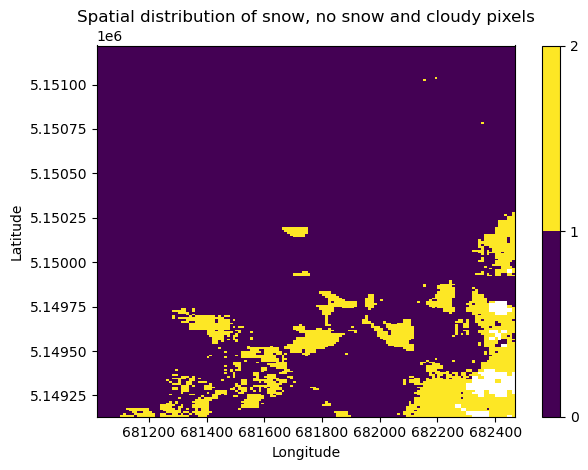

In [69]:
snowmap.plot(levels=[0, 1, 2])
plt.title("Spatial distribution of snow, no snow and cloudy pixels")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.tight_layout()

Let's have a look at the histogram to understand the distribution of the values in our map

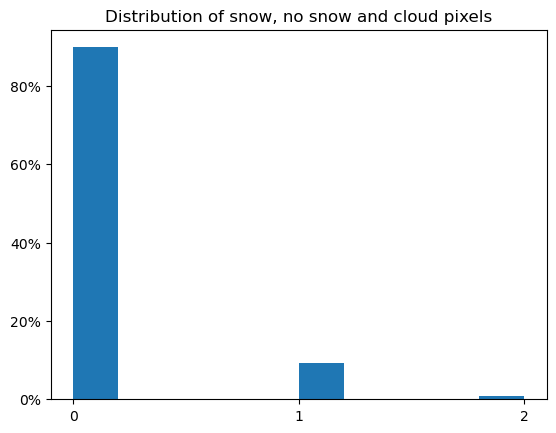

In [96]:
data = snowmap.values.flatten()
snowmap.plot.hist(xticks = [0, 1, 2], weights=np.ones(len(data)) / len(data))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Distribution of snow, no snow and cloud pixels")
plt.show()

## Load STAC metadata
In addition to the COG we also receive STAC metadata for our result.
Let's have a look at it.

In [62]:
stac_collection = results.get_metadata()
stac_collection

{'assets': {'openEO.tif': {'file:nodata': ['nan'],
   'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-240130d5028a4abd8b4a0d34b8e84fe8/results/assets/MDYxODNjYmMtODRjOC00YzZhLThhN2QtY2IxOGJhMDhjYzhj/e08a0052b037426901a08366cf365369/openEO.tif?expires=1707233820',
   'raster:bands': [{'name': '1',
     'statistics': {'maximum': 2.0,
      'mean': 0.089952153110048,
      'minimum': 0.0,
      'stddev': 0.28504438766767,
      'valid_percent': 100.0}}],
   'roles': ['data'],
   'title': 'openEO.tif',
   'type': 'image/tiff; application=geotiff'}},
 'description': 'Results for batch job j-240130d5028a4abd8b4a0d34b8e84fe8',
 'extent': {'spatial': {'bbox': [None]},
  'temporal': {'interval': [[None, None]]}},
 'id': 'j-240130d5028a4abd8b4a0d34b8e84fe8',
 'license': 'proprietary',
 'links': [{'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-240130d5028a4abd8b4a0d34b8e84fe8/results',
   'rel': 'self',
   'type': 'application/json'},
  {'href': 'https://opene

### Adding Author of the data

Add your information to become visible as author of the data -  description of each field can be found here: https://github.com/radiantearth/stac-spec/blob/master/item-spec/common-metadata.md#provider-object

Please note that leaving the field empty will lead to failed validation of STAC item

**Attention:** Enter your full name and a short description of the snowmap you generated e.g. `name = "Jane Doe"` and `description = "snow map of Merano"`

In [31]:
name = ""
description = ""

In [32]:
author = [{
    "name": name,
    "description": description,
    "roles": ["processor"],
}]

providers = stac_collection["providers"] + author

author_id = [nam[:2] for nam in author[0]["name"].split(" ")]

# generate timestamp
ts = datetime.now().isoformat()
ts = ts.split("T")[0]

Extract bbox information and temporal extent from the STAC collection that was delivered with the result from OpenEO. We are reusing it to create our STAC item. We have prepared these function for you `extract_metadata_geometry` and `extract_metadata_time`

In [33]:
geometry = extract_metadata_geometry(stac_collection)[1]

In [34]:
start_time, end_time = extract_metadata_time(stac_collection)

Since we calculated the statistics and renamed the file, we have to add this new file name to the STAC item.

In [44]:
filename = "openEO_uint8.tif"

Let's create the actual STAC item describing your data! As talked about in previous lessons, STAC item has various required fields which need to be present and filled correctly. For the field ID we assign the fixed name snowcover and the initials of your name. That will be visible on the STAC browser once you have submitted the result!

In [45]:
stac_item = {
    "type": "Feature", 
    "stac_version": stac_collection["stac_version"],
    "stac_extensions": [],
    "id": "snowcover_" + "".join(author_id).lower()+ "_" + str(ts),
    "geometry": geometry,
    "bbox": bbox,
    
    "properties": {
       "datetime": None, 
        "start_datetime": start_time,
        "end_datetime": end_time,
        "providers" : providers
                 },
    
    "links": stac_collection["links"],
    "assets": {"visual": {
      "href": filename,
      "type": "image/tiff; application=geotiff; profile=cloud-optimized",
      "title": "Snow coverage",
      "roles": [
        "data"
              ]
            }
        },
}

In [46]:
stac_item

{'type': 'Feature',
 'stac_version': '1.0.0',
 'stac_extensions': [],
 'id': 'snowcover_ruomba_2024-01-30',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[11.358779783940813, 46.47144682641322],
    [11.376766216059186, 46.47144682641322],
    [11.376766216059186, 46.48979317358678],
    [11.358779783940813, 46.48979317358678],
    [11.358779783940813, 46.47144682641322]]]},
 'bbox': (11.358779783940813,
  46.47144682641322,
  11.376766216059186,
  46.48979317358678),
 'properties': {'datetime': None,
  'start_datetime': '2023-02-01T00:00:00Z',
  'end_datetime': '2023-06-01T00:00:00Z',
  'providers': [{'description': 'This data was processed on an openEO backend maintained by VITO.',
    'name': 'VITO',
    'processing:expression': [{'expression': {'loadcollection1': {'arguments': {'bands': ['B03',
          'B11',
          'SCL'],
         'id': 'SENTINEL2_L2A',
         'spatial_extent': {'crs': 4326,
          'east': 11.376766216059186,
          'north': 46.48979317358678,


Saving the resulting item as stac_item.json into results folder

In [47]:
stac_json = json.dumps(stac_item)
with open("33_results/stac_item.json", "w") as file:
    file.write(stac_json)

Validating that STAC item is important - non valid STAC will not be displayed in the STAC browser after upload

In [48]:
from stac_validator import stac_validator
import requests
stac = stac_validator.StacValidate()
f = open('33_results/stac_item.json')
data = json.load(f)
stac.validate_dict(data)
print(stac.message)

[{'version': '1.0.0', 'path': None, 'schema': ['https://schemas.stacspec.org/v1.0.0/item-spec/json-schema/item.json'], 'valid_stac': True, 'asset_type': 'ITEM', 'validation_method': 'default'}]


### Now it is time to upload solution to the submission folder and make results visible in STAC browser

Upload both the STAC json file and the final .tif file to "submissions" folder in your home directory

You can use the code below to copy the results to the submissions folder

In [49]:
!cp ./33_results/stac_item.json ~/submissions/
!cp ./33_results/openEO_uint8.tif ~/submissions/

And now by executing the cell below, update of the STAC browser will start. By this, you are uploading your results to the openly available STAC browser. This might take some minutes.

In [50]:
env_var1 = os.getenv('EMAIL')
curl_command = f"curl -X POST -F token=glptt-42d31ac6f592a9e321d0e4877e654dc50dcf4854 -F ref=main -F 'variables[USER_DIRECTORY]=\"{env_var1}\"' https://gitlab.eox.at/api/v4/projects/554/trigger/pipeline" 
process = subprocess.Popen(curl_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

### Your results are online!
You can now browse your results together with all the other submissions at the publicly available STAC Catalog! You can check your snow cover map, that you are correctly listed as the author and that your contribution has the correct name. The license on the STAC Collection "Cubes and Clouds: Snow Cover" is CC-BY-4.0. The STAC Collection also has it's own DOI.

Congratulations you have just contributed to a community mapping project that is completely open source, open data and FAIR! Make sure to show it also to your friends, colleagues or potential employers :)

https://esa.pages.eox.at/cubes-and-clouds-catalog/browser/#/?.language=en

If you would like to redo your submission, you can still update your files in submissions folder and once ready, run again the code in the cell above. 

**Attention:** If you have previously opened the STAC browser, your old submission will be cached and not directly displayed. To circumvent this, open a private window from your browser.

Happy coding!